In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib notebook

import os
import sys

module_path = os.path.abspath(os.path.join(".."))
if module_path not in sys.path:
    sys.path.append(module_path)
    
from lib.pk_tools import pk_tools

In [2]:
data_path = "../data/Patchy_V6C_BOSS_DR12_NGC_z1"
all_filenames = os.listdir(data_path)

# Number of bins (random variables)
p = 120

# Select n random filenames
n = 50
indices = np.random.choice(len(all_filenames), n, replace=False)
filenames = np.array(all_filenames)[indices]

# Empty power spectrum matrix
P = np.empty((p, len(filenames)))

i = 0;
for filename in filenames:
    # Load the data using Beutler's pk_tools module 
    data = pk_tools.read_power(os.path.join(data_path, filename), combine_bins=10)

    # Assign labels to data
    P0 = data['pk0']
    P2 = data['pk2']
    P4 = data['pk4']
    
    # Add total data as one column vector to the power spectrum matrix
    P[:,i] = np.concatenate((P0, P2, P4))
    i += 1

print(P.shape)

(120, 50)


In [3]:
P_mean = np.sum(P, axis=1)/n # Find mean of each row
P_mean_matrix = np.tile(P_mean, (n, 1)).T # Repeat mean values as columns in a p x n matrix
X = P - P_mean_matrix

W = []
# Generate W array (which is 3D) of size (n, p, p), order of indices (k, i, j)
for k in range(n):
    w = X[:,k]
    W.append(np.outer(w, w))
W_mean = np.sum(W, axis=0)/n

# Emperically estimated covariance matrix
S = n / (n-1) * W_mean

# Take as Target the diagonal elements of the sample cov matrix
T = np.diag(np.diag(S))

W_mean_rep = np.tile(W_mean, (n, 1, 1))
V = W - W_mean_rep
# Compute variance of elements of the covariance matrix
Var = n / (n-1)**3 * np.sum(V**2, axis=0)

# Compute estimated shrinkage intensity parameter lambda
lmbda_est = np.sum(Var-np.diag(np.diag(Var))) / np.sum((T-S)**2)
print(lmbda_est)

# Compute shrinkage covariance matrix
cov_shrinkage = lmbda_est*T + (1-lmbda_est)*S

0.4851935470363883


In [4]:
# 'Real' covariance matrix before processing.
# The term 'real' here indicates that this is the matrix that we use to compare
# our estimates to.
cov_real_preproc = np.loadtxt("../data/C_2048_BOSS_DR12_NGC_z1_V6C_1_1_1_1_1_10_200_200_prerecon.matrix")
indices = np.concatenate((np.arange(40), np.arange(40)+80, np.arange(40)+160))
cov_real = (cov_real_preproc[indices, :])[:, indices]

In [5]:
evals_shrinkage = np.linalg.eigvalsh(cov_shrinkage)
evals_sample = np.linalg.eigvalsh(S)
evals_target = np.linalg.eigvalsh(T)
evals_real = np.linalg.eigvalsh(cov_real)

<IPython.core.display.Javascript object>


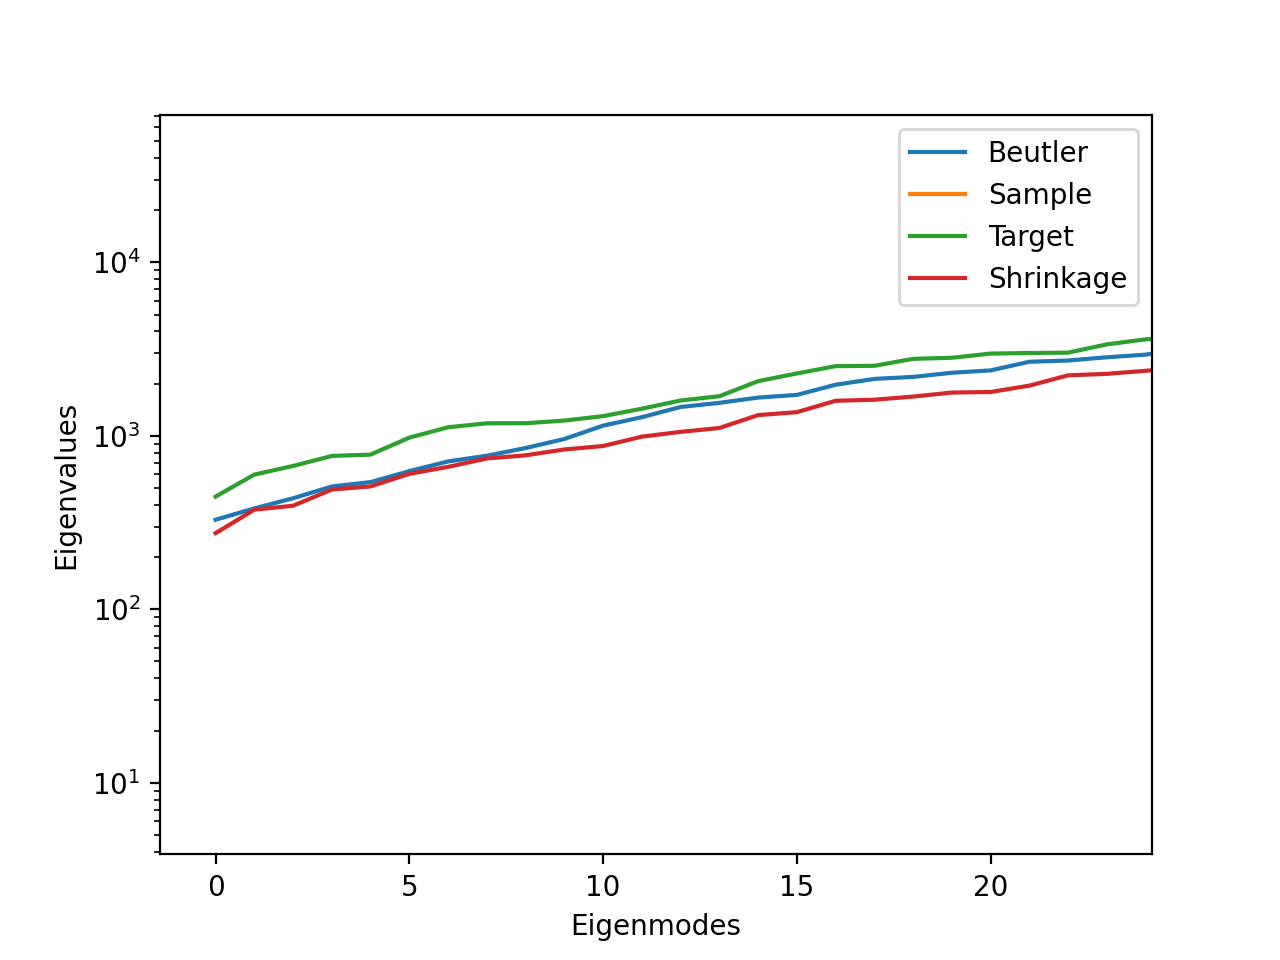

Text(0, 0.5, 'Eigenvalues')

In [6]:
plt.plot(evals_real, label="Beutler")
plt.plot(evals_sample, label="Sample")
plt.plot(evals_target, label="Target")
plt.plot(evals_shrinkage, label="Shrinkage")
plt.yscale("log")
plt.legend()
plt.xlabel("Eigenmodes")
plt.ylabel("Eigenvalues")